# Integrate and plot sound, environmental, and climatology data

You don't need to run the installation when on mybinder, this has been taken care of for you

In [120]:
!pip install rioxarray
!pip install hvplot
!pip install geopandas
!pip install cartopy
!pip install geoviews

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 262.5 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 6.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 181.9 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.2/563.2 kB 1.9 MB/s eta 0:00:0000:0100:01


In [ ]:
import pathlib
import warnings
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from datetime import datetime, timedelta
import hvplot.pandas
from shapely import wkt, geometry
import geopandas as gpd
import minio

In [ ]:
# Supress warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

# Clear out default notebook settings
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# Set figure size and layout
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True

## Set sound and environmental dataset variables

Find variables by exploring https://soundcoop.portal.axds.co.

In [ ]:
erddap_dataset = 'gov-ndbc-44007'
sound_dataset = 'Monh'
max_days = 25
start_date_time = '2021-10-23T20:11:53.211'
end_date_time = '2021-11-18T07:28:18.297'
min_frequency = 21
max_frequency = 24000

In [ ]:
# Update end_date_time if defined temporal range exceeds max_days
time_delta = datetime.fromisoformat(end_date_time) - datetime.fromisoformat(start_date_time)
if time_delta.days > max_days:
    end_date_time = str(datetime.fromisoformat(start_date_time) + timedelta(days=max_days))
    print(f'end_date_time updated to {end_date_time}')

## Download data

In [167]:
# First we create a function to download data 
def download_data_station(station_name, 
                          client_obj, 
                          bucket_str, 
                          prefix_str, 
                          data_path,
                          name_format,
                          start_datetime, 
                          end_datetime):
    start_datetime_obj = datetime.fromisoformat(start_datetime) 
    end_datetime_obj = datetime.fromisoformat(end_datetime)
    station_folder = pathlib.Path(data_path).joinpath(station_name)
    if not station_folder.exists():
        os.mkdir(station_folder)
    objects = list(client_obj.list_objects(bucket_str, prefix=prefix_str))
    ct = 0
    for i, obj in enumerate(objects):
        object_name = obj.object_name
        path_name = pathlib.Path(object_name).name
        if (not path_name.startswith('.')) & path_name.endswith('.nc'):
            file_date = datetime.strptime(path_name, name_format)
            if (file_date >= start_datetime_obj) & (file_date <= end_datetime_obj):
                download_path = data_path + '/' + station_name + '/' + pathlib.Path(object_name).name
                if os.path.isfile(download_path):
                    print('Already downloaded: ' + download_path)
                else:
                    print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
                    object_data = client.get_object(bucket, object_name)
                    if not os.path.isdir(download_path):
                        with open(str(download_path), 'wb') as file_data:
                            for data in object_data:
                                file_data.write(data)
                    file_data.close()
            else: 
                print('Ignored, out of selected period or not a netCDF file ' + path_name)
        ct += 1

In [168]:
# Define file paths -- can be a string glob or list of explicit paths
local_path = './../data'
sound_paths = local_path + '/' + sound_dataset + '/*.nc'

In [169]:
# Set up the download for NRS11 data 
client = minio.Minio('storage.googleapis.com')
bucket = 'noaa-passive-bioacoustic'
station = 'NRS11'
prefix = 'soundcoop/%s/' % station
name_format = 'NRS11_H5R6.1.5000_%Y%m%d_DAILY_MILLIDEC_MinRes_v2.nc'
download_data_station(station, client, bucket, prefix, local_path, name_format=name_format, start_datetime=start_date_time, end_datetime=end_date_time)

Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191023_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191024_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191025_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191026_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191027_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191028_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191029_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191030_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191031_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected per

## Read in and clean up sound data

In [106]:
# Define file paths -- can be a string glob or list of explicit paths
local_path = './../data'
sound_paths = local_path + '/' + sound_dataset + '/*.nc'

In [ ]:
# Read in data, dropping variables that are sometimes inconsistent across files to 
# prevent open_mfdataset from complaining
sound_ds = xr.open_mfdataset(
    sound_paths,
    engine='netcdf4'
)

# Filter data by defined temporal and frequency ranges
sound_ds = sound_ds.sel(
    time=slice(start_date_time, end_date_time),
    frequency=slice(min_frequency, max_frequency)
)

# Remove data flagged as low quality
minimum_quality = 3
if hasattr(sound_ds, 'quality_flag'):
    sound_ds['psd'] = sound_ds.psd.where(sound_ds.quality_flag <= minimum_quality)

sound_ds

<<<<<<< local


<xarray.Dataset>
Dimensions:             (time: 36677, frequency: 1174, cal_frequency: 3206)
Coordinates:
  * time                (time) datetime64[ns] 2021-01-23T20:12:00 ... 2021-02...
  * frequency           (frequency) float64 21.0 22.0 ... 2.492e+03 2.498e+03
  * cal_frequency       (cal_frequency) float64 0.0 1.0 ... 2.556e+05 2.56e+05
Data variables:
    timestamp           (time) timedelta64[ns] dask.array<chunksize=(228,), meta=np.ndarray>
    effort              (time) timedelta64[ns] dask.array<chunksize=(228,), meta=np.ndarray>
    psd                 (time, frequency) float64 dask.array<chunksize=(228, 1174), meta=np.ndarray>
    quality_flag        (time, frequency) int8 dask.array<chunksize=(228, 1174), meta=np.ndarray>
    analog_sensitivity  (time, cal_frequency) float64 dask.array<chunksize=(228, 3206), meta=np.ndarray>
    preamp_gain         (time, cal_frequency) float64 dask.array<chunksize=(228, 3206), meta=np.ndarray>
    recorder_gain       (time, cal_frequency) float64 dask.array<chunksize=(228, 3206), meta=np.ndarray>
    sensor_sensitivity  (time, cal_frequency) float64 dask.array<chunksize=(228, 3206), meta=np.ndarray>
Attributes: (12/36)
    acknowledgement:                             These products support the P...
    citation:                                    Cite as: NOAA OAR Pacific Ma...
    comment:                                     Data quality: Good 2019-10-2...
    conventions:                                 COARDS, CF-1.6, ACDD-1.3
    creator_name:                                Robert Dziak, Jason Gedamke,...
    creator_role:                                Principal Investigator
    ...                                          ...
    title:                                       Hybrid Millidecade Band Soun...
    PreampFixedGain_dB:                          0.0
    SamplingRate:                                5000
    CalibrationFrequency_Hz:                     0.0
    CalibrationSensitivity_dB_re_1VperRefPress:  0.0
    CalibrationDate:

<xarray.Dataset>
Dimensions:             (time: 36677, frequency: 1174, cal_frequency: 3206)
Coordinates:
  * time                (time) datetime64[ns] 2021-01-23T20:12:00 ... 2021-02...
  * frequency           (frequency) float64 21.0 22.0 ... 2.492e+03 2.498e+03
  * cal_frequency       (cal_frequency) float64 0.0 1.0 ... 2.556e+05 2.56e+05
Data variables:
    timestamp           (time) timedelta64[ns] dask.array<chunksize=(228,), meta=np.ndarray>
    effort              (time) timedelta64[ns] dask.array<chunksize=(228,), meta=np.ndarray>
    psd                 (time, frequency) float64 dask.array<chunksize=(228, 1174), meta=np.ndarray>
    quality_flag        (time, frequency) int8 dask.array<chunksize=(228, 1174), meta=np.ndarray>
    analog_sensitivity  (time, cal_frequency) float64 dask.array<chunksize=(228, 3206), meta=np.ndarray>
    preamp_gain         (time, cal_frequency) float64 dask.array<chunksize=(228, 3206), meta=np.ndarray>
    recorder_gain       (time, cal_frequency) float64 dask.array<chunksize=(228, 3206), meta=np.ndarray>
    sensor_sensitivity  (time, cal_frequency) float64 dask.array<chunksize=(228, 3206), meta=np.ndarray>
Attributes: (12/36)
    acknowledgement:                             These products support the P...
    citation:                                    Cite as: NOAA OAR Pacific Ma...
    comment:                                     Data quality: Good 2019-10-2...
    conventions:                                 COARDS, CF-1.6, ACDD-1.3
    creator_name:                                Robert Dziak, Jason Gedamke,...
    creator_role:                                Principal Investigator
    ...                                          ...
    title:                                       Hybrid Millidecade Band Soun...
    PreampFixedGain_dB:                          0.0
    SamplingRate:                                5000
    CalibrationFrequency_Hz:                     0.0
    CalibrationSensitivity_dB_re_1VperRefPress:  0.0
    CalibrationDate:

>>>>>>> remote


## Download and wrangle environmental data

In [ ]:
erddap_base_url = 'https://erddap.sensors.ioos.us/erddap'

In [109]:
# Get environmental sensor station lat/lon for use in mapping and querying water temperature climatology data
erddap_metadata_url = f'{erddap_base_url}/info/{erddap_dataset}/index.csv'
env_metadata_df = pd.read_csv(erddap_metadata_url)

env_station_x = env_metadata_df.loc[env_metadata_df['Attribute Name'] == 'geospatial_lon_min']['Value'].item()
env_station_y = env_metadata_df.loc[env_metadata_df['Attribute Name'] == 'geospatial_lat_min']['Value'].item()

wind_speed_units_row = env_metadata_df[
    (env_metadata_df['Row Type'] == 'attribute') & 
    (env_metadata_df['Attribute Name'] == 'units') & 
    (env_metadata_df['Variable Name'] == 'wind_speed')
]
wind_speed_units = wind_speed_units_row.iloc[0]['Value']
wind_speed_units


'm.s-1'

In [110]:
wind_speed_to_kts_factors = {
    "m.s-1": 1.94384,
    "mph": 0.86897423357831,
    "kmh": 0.53995555554212126825,
    "ft.s-1": 0.59248243198521155506
}

In [111]:
if wind_speed_units in wind_speed_to_kts_factors:
    print("Success! Units can be converted from", wind_speed_units,'to','kts')
else:
    print("Error! Wind speed cannot be converted from", wind_speed_units,'to','kts')

Success! Units can be converted from m.s-1 to kts


In [112]:
# Grab the same time range covered by the sound data
time_start = np.datetime_as_string(sound_ds.time.min().to_pandas())
time_end = np.datetime_as_string(sound_ds.time.max().to_pandas())

wind_var = 'wind_speed'
swt_var = 'sea_surface_temperature'
wave_var = 'sea_surface_wave_significant_height'
anomaly_var = 'swt_anomaly'
wind_var_kts = 'wind_speed_kts'

erddap_dataset_url = (
    f'{erddap_base_url}/tabledap/{erddap_dataset}.csv'
    f'?time,{wind_var},{swt_var},{wave_var}&time>={time_start}&time<={time_end}'
)

In [113]:
env_df = pd.read_csv(
    erddap_dataset_url,
    skiprows=[1]  # The second row (index 1) are the column units, which we don't need
)

In [114]:
# Format the time field and set it as the index
env_df['time'] = pd.to_datetime(env_df['time'])
env_df['wind_speed_kts']=env_df['wind_speed'].apply(lambda x : x*wind_speed_to_kts_factors[wind_speed_units])
env_df = env_df.set_index('time').sort_index()
env_df

,wind_speed,sea_surface_temperature,sea_surface_wave_significant_height,wind_speed_kts
time,,,,
2021-01-23 20:20:00+00:00,9.0,5.0,NaN,17.494560
2021-01-23 20:30:00+00:00,9.5,5.0,NaN,18.466480
2021-01-23 20:40:00+00:00,10.3,5.0,0.83,20.021552
2021-01-23 20:50:00+00:00,9.7,5.0,NaN,18.855248
2021-01-23 21:00:00+00:00,9.6,5.0,NaN,18.660865
...,...,...,...,...
2021-02-18 06:40:00+00:00,6.2,3.5,0.50,12.051808
2021-02-18 06:50:00+00:00,6.1,NaN,NaN,11.857424
2021-02-18 07:00:00+00:00,6.3,3.5,NaN,12.246192


In [115]:
# Save CSV of environmental data
env_df.to_csv(f'env_df_{erddap_dataset}.csv')

## Map station locations

In [116]:
sound_station_pt = wkt.loads(sound_ds.attrs['geospatial_bounds'])

# Some statoins (e.g. PManan) have their WKT coordinates reversed -- should be x, y (long, lat)
if sound_station_pt.x > 0:
    sound_station_x = sound_station_pt.y
    sound_station_y = sound_station_pt.x
else:
    sound_station_x = sound_station_pt.x
    sound_station_y = sound_station_pt.y


In [117]:
float(env_station_x)

-70.14

In [121]:
stations_gdf = gpd.GeoDataFrame(
    {
        'station': [f'{sound_dataset}', f'{erddap_dataset}'],
        'geometry': [
            geometry.Point(float(sound_station_x), float(sound_station_y)),
            geometry.Point(float(env_station_x), float(env_station_y))
        ]
    },
    crs='epsg:4326'
)

In [122]:
stations_gdf.hvplot.points(color='station', size=100, geo=True, tiles=True, frame_width=700, frame_height=500)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (station)

## Merge sound and environmental data

In [123]:
# Temporal resolution to which we'll resample the sound and environmental data
# in order to merge them and plot them against each other
temporal_resolution = 'h'

In [124]:
# Convert env_df to an Xarray Dataset so it can be merged with the sound data
env_ds = env_df.to_xarray()
env_ds['time'] = pd.DatetimeIndex(env_ds['time'].values)

In [125]:
# Resample sound and environmental data and merge in to a single Xarray Dataset
ds = xr.merge([
    sound_ds.psd.resample(time=temporal_resolution).median(),
    env_ds.resample(time=temporal_resolution).mean()
])
ds

<xarray.Dataset>
Dimensions:                              (frequency: 1174, time: 612)
Coordinates:
  * frequency                            (frequency) float64 21.0 ... 2.498e+03
  * time                                 (time) datetime64[ns] 2021-01-23T20:...
Data variables:
    psd                                  (time, frequency) float64 dask.array<chunksize=(1, 1174), meta=np.ndarray>
    wind_speed                           (time) float64 9.625 9.817 ... 6.567
    sea_surface_temperature              (time) float64 5.0 5.0 ... 3.56 3.533
    sea_surface_wave_significant_height  (time) float64 0.83 0.74 ... 0.5 nan
    wind_speed_kts                       (time) float64 18.71 19.08 ... 12.76
Attributes:
    long_name:              Single-sided mean-square sound pressure spectral ...
    standard_name:          sound_intensity_in_water
    units:                  dB
    comment:                Computation of single-sided mean-square sound pre...
    coverage_content_type:  physicalMeasurement

## Calculate and integrate temperature anomaly data

In [126]:
def get_woa23_temp_at_xy(x, y, month, var='t_mn', depth=0):
    """
    Get 1-degree WOA 2023 temperature values for a given point and month.

    Args:
        x: A longitude value given in decimal degrees
        y: A latitude value given in decimal degrees
        month: The month asn integer from which to extract the value
        var (optional): The temperature variable to use. Defaults to the statistical mean.
        depth (optional): The depth at which to extract the value. Defaults to the surface.
    """
    url = (
        'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'
        f'temperature/netcdf/decav/1.00/woa23_decav_t{month:02}_01.nc'
    )
    ds = xr.open_dataset(
        url,
        decode_times=False  # xarray can't handle times defined as "months since ..."
    )

    da = ds.isel(depth=depth)[var]  # Pull out just the variable we're interested in

    # Because nearshore locations are often NaN due to the grid's low resolution
    # we need to interpolate the NaNs to the nearest non-NaN before extracting our value.
    # We use rioxarray to do the interpolations in two dimensions because plain vanilla xarray
    # can only interpolate in one dimension.
    da = da.rio.write_crs(4326)
    da = da.rio.interpolate_na(method='nearest')

    # Then we extract the value, also using the nearest neighbor method because the given
    # x and y values are unlikely to fall exactly on one of the grid's lat/lon coordinate pairs
    val = da.sel(lon=x, lat=y, method='nearest').item()

    return val

In [127]:
# Define the location of our selected ERDDAP dataset
# Override here if needed
x = env_station_x
y = env_station_y

In [128]:
url = (
    'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'
    f'temperature/netcdf/decav/1.00/woa23_decav_t07_01.nc'
)
da = xr.open_dataset(
    url,
    decode_times=False  # xarray can't handle times defined as "months since ..."
).isel(depth=0)['t_mn']  # Pull out just the variable we're interested in


In [129]:
da

<xarray.DataArray 't_mn' (time: 1, lat: 180, lon: 360)>
[64800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    depth    float32 0.0
  * time     (time) float32 402.5
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Average of all unflagged interpolated values at each stan...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius
    _ChunkSizes:    [  1  29  90 180]

In [130]:

# Because nearshore locations are often NaN due to the grid's low resolution
# we need to interpolate the NaNs to the nearest non-NaN before extracting our value.
# We use rioxarray to do the interpolations in two dimensions because plain vanilla xarray
# can only interpolate in one dimension.
da = da.rio.write_crs(4326)
da = da.rio.interpolate_na(method='nearest')
da

<xarray.DataArray 't_mn' (time: 1, lat: 180, lon: 360)>
array([[[-1.802    , -1.802    , -1.7709999, ..., -1.8334   ,
         -1.8334   , -1.8334   ],
        [-1.802    , -1.802    , -1.7709999, ..., -1.8334   ,
         -1.8334   , -1.8334   ],
        [-1.802    , -1.802    , -1.7709999, ..., -1.8334   ,
         -1.8334   , -1.8334   ],
        ...,
        [-1.457737 , -1.457737 , -1.457737 , ..., -1.757737 ,
         -1.757737 , -1.757737 ],
        [-1.457737 , -1.457737 , -1.457737 , ..., -1.757737 ,
         -1.757737 , -1.757737 ],
        [-1.457737 , -1.457737 , -1.457737 , ..., -1.757737 ,
         -1.757737 , -1.757737 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    depth    float32 0.0
  * time     (time) float32 402.5
    crs      int64 0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Average of all unflagged interpolated values at each stan...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    units:          degrees_celsius
    _ChunkSizes:    [  1  29  90 180]

In [131]:
da.coords

Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    depth    float32 0.0
  * time     (time) float32 402.5
    crs      int64 0

In [132]:
# Then we extract the value, also using the nearest neighbor method because the given
# x and y values are unlikely to fall exactly on one of the grid's lat/lon coordinate pairs
val = da.sel(lon=x, lat=y, method='nearest').item()
val

17.7031307220459

In [133]:
ds

<xarray.Dataset>
Dimensions:                              (frequency: 1174, time: 612)
Coordinates:
  * frequency                            (frequency) float64 21.0 ... 2.498e+03
  * time                                 (time) datetime64[ns] 2021-01-23T20:...
Data variables:
    psd                                  (time, frequency) float64 dask.array<chunksize=(1, 1174), meta=np.ndarray>
    wind_speed                           (time) float64 9.625 9.817 ... 6.567
    sea_surface_temperature              (time) float64 5.0 5.0 ... 3.56 3.533
    sea_surface_wave_significant_height  (time) float64 0.83 0.74 ... 0.5 nan
    wind_speed_kts                       (time) float64 18.71 19.08 ... 12.76
Attributes:
    long_name:              Single-sided mean-square sound pressure spectral ...
    standard_name:          sound_intensity_in_water
    units:                  dB
    comment:                Computation of single-sided mean-square sound pre...
    coverage_content_type:  physicalMeasurement

In [134]:
# Assemble a mapping between months and WOA 2023 temperature values
months = list(range(1, 13))
temps = [get_woa23_temp_at_xy(x, y, m) for m in months]
clim_dict = {m: t for m, t in zip(months, temps)}
clim_dict

{1: 5.947936534881592,
 2: 5.027897834777832,
 3: 4.140866279602051,
 4: 4.927887439727783,
 5: 8.448789596557617,
 6: 12.741324424743652,
 7: 17.7031307220459,
 8: 18.909664154052734,
 9: 16.915424346923828,
 10: 13.209051132202148,
 11: 10.214630126953125,
 12: 7.829346179962158}

In [139]:
# Calculate the sea water temperature anomaly by subtracting the monthly WOA 2023 temperature value
# from each measured sea water temperature value and store it as a new variable
ds[anomaly_var] = ds[swt_var] - [clim_dict[m] for m in ds.time.dt.month.values]
ds

<xarray.Dataset>
Dimensions:                              (frequency: 1174, time: 612)
Coordinates:
  * frequency                            (frequency) float64 21.0 ... 2.498e+03
  * time                                 (time) datetime64[ns] 2021-01-23T20:...
Data variables:
    psd                                  (time, frequency) float64 dask.array<chunksize=(1, 1174), meta=np.ndarray>
    wind_speed                           (time) float64 9.625 9.817 ... 6.567
    sea_surface_temperature              (time) float64 5.0 5.0 ... 3.56 3.533
    sea_surface_wave_significant_height  (time) float64 0.83 0.74 ... 0.5 nan
    wind_speed_kts                       (time) float64 18.71 19.08 ... 12.76
    swt_anomaly                          (time) float64 -0.9479 ... -1.495
Attributes:
    long_name:              Single-sided mean-square sound pressure spectral ...
    standard_name:          sound_intensity_in_water
    units:                  dB
    comment:                Computation of single-sided mean-square sound pre...
    coverage_content_type:  physicalMeasurement

In [140]:
# Save NetCDF of merged data
ds.to_netcdf(f'merged_data_{sound_dataset}_{erddap_dataset}.nc')

In [141]:
# Save CSV of merged data
ds.to_dataframe().to_csv(f'merged_data_{sound_dataset}_{erddap_dataset}.csv')

## Plot resampled raw data

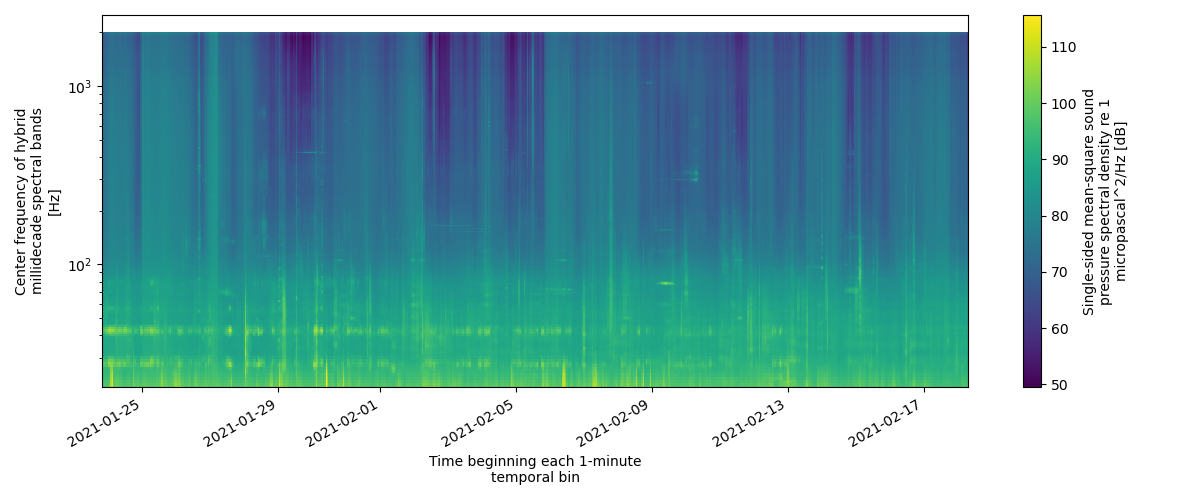

In [142]:
# Plot resampled sound data
ds.psd.plot(x='time', yscale='log')
plt.show()

In [143]:
ds

<xarray.Dataset>
Dimensions:                              (frequency: 1174, time: 612)
Coordinates:
  * frequency                            (frequency) float64 21.0 ... 2.498e+03
  * time                                 (time) datetime64[ns] 2021-01-23T20:...
Data variables:
    psd                                  (time, frequency) float64 dask.array<chunksize=(1, 1174), meta=np.ndarray>
    wind_speed                           (time) float64 9.625 9.817 ... 6.567
    sea_surface_temperature              (time) float64 5.0 5.0 ... 3.56 3.533
    sea_surface_wave_significant_height  (time) float64 0.83 0.74 ... 0.5 nan
    wind_speed_kts                       (time) float64 18.71 19.08 ... 12.76
    swt_anomaly                          (time) float64 -0.9479 ... -1.495
Attributes:
    long_name:              Single-sided mean-square sound pressure spectral ...
    standard_name:          sound_intensity_in_water
    units:                  dB
    comment:                Computation of single-sided mean-square sound pre...
    coverage_content_type:  physicalMeasurement

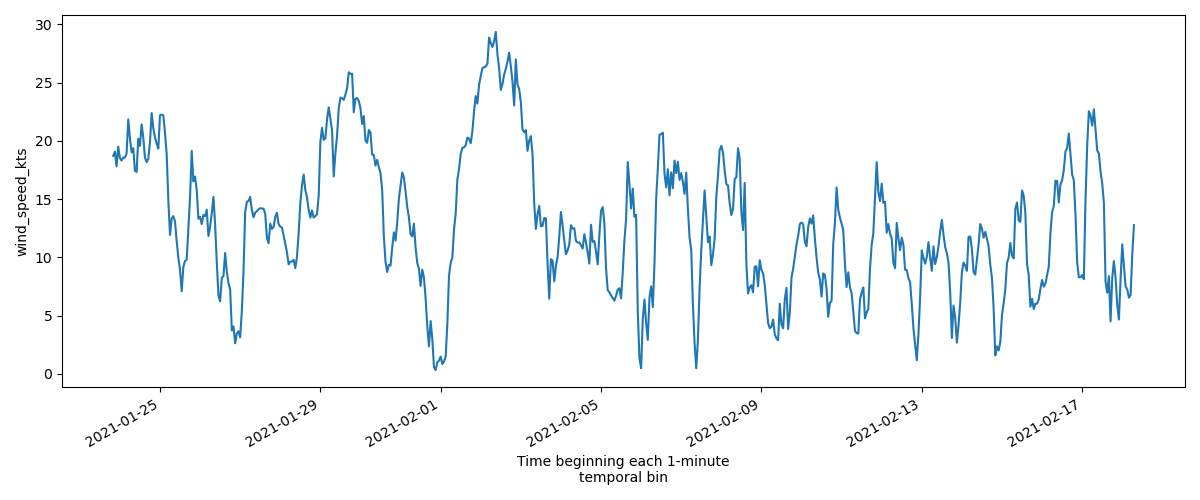

In [144]:
# Plot resampled wind data
ds[wind_var_kts].plot()
plt.show()

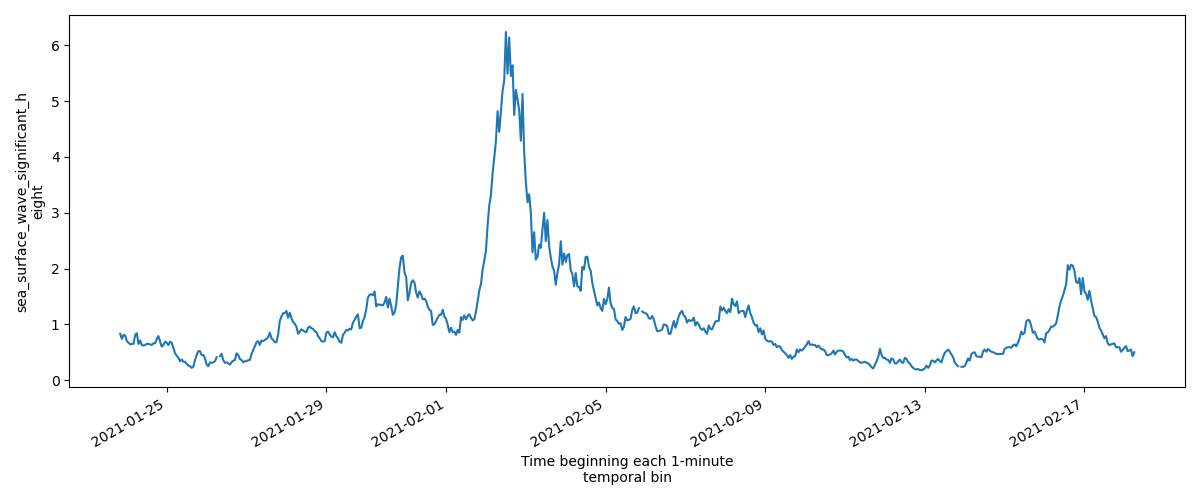

In [145]:
# Plot resampled wave data
ds[wave_var].plot()
plt.show()

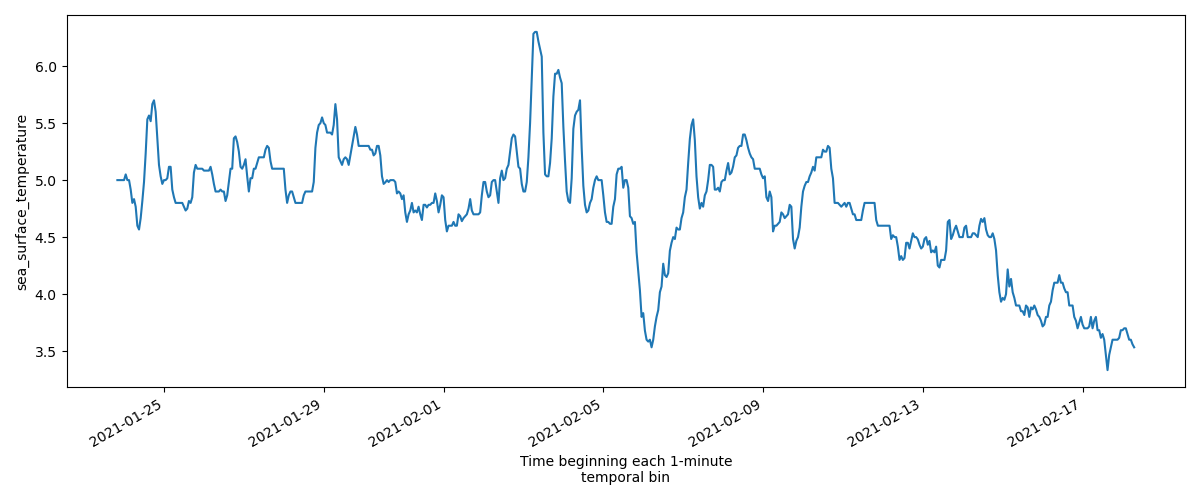

In [146]:
# Plot resampled water temperature data
ds[swt_var].plot()
plt.show()

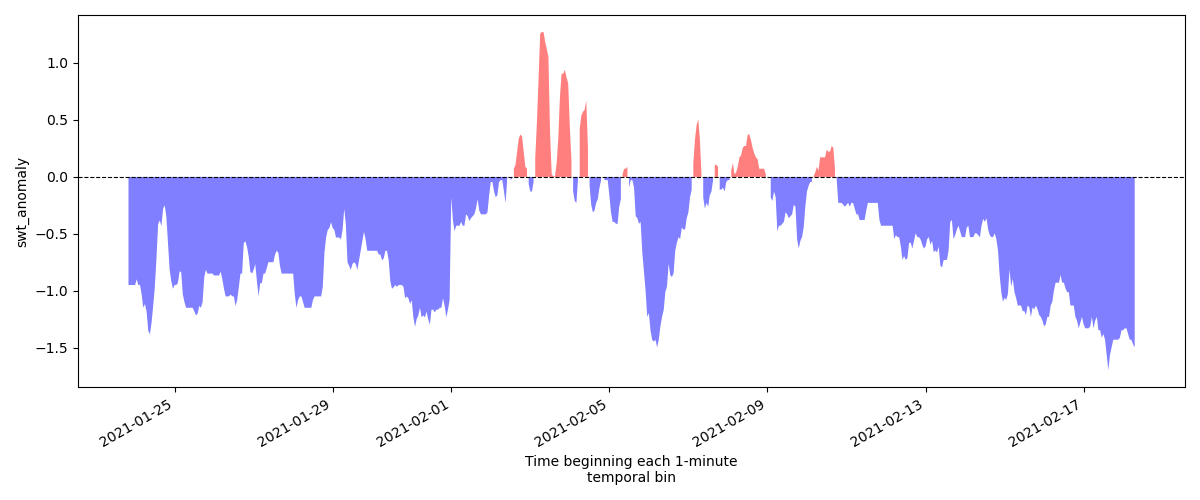

In [147]:
# Plot water temperature anomaly data
ds[anomaly_var].plot(linestyle='')
plt.fill_between(ds.time, ds[anomaly_var], 0, where=(ds[anomaly_var] < 0), facecolor='blue', alpha=0.5)
plt.fill_between(ds.time, 0, ds[anomaly_var], where=(ds[anomaly_var] >= 0), facecolor='red', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.show()

## Plot power spec

In [148]:
def plot_power_spec(
    ds, 
    conditions=None,
    title=None,
    xlabel='Frequency (hz)', 
    ylabel='Sound pressure level (db)', # use netcdf attribute
    envelope=True
):
    """
    Produces power spec plot given zero or more conditions and labels

    Args:
        ds: An Xarray Dataset consisting of both sound and environmental variables.
        conditions (optional): A single tuple or list of tuples, where each tuple is 
            a condition-label pair, the condition representing a conditional statement to
            be passed to ds.where() and each label representing that condition's legend label.
        title (optional): The plot title.
        xlabel (optional): The X-axis label.
        ylabel (optional): The Y-axis label.
        envelope (optional): Whether or not to plot the 10th to 90th quantile envelope
    """
    fig, ax = plt.subplots()

    # If no conditions were specified, just plot everything
    if conditions is None:
        ds.psd.median(dim='time').plot(x='frequency', xscale='log', ax=ax)

        # Add 10th to 90th quantile envelope
        if envelope:
            plt.fill_between(
                ds.frequency,
                ds.psd.chunk(dict(time=-1)).quantile(0.9, dim='time'),
                ds.psd.chunk(dict(time=-1)).quantile(0.1, dim='time'),
                alpha=0.25
            )

    else:

        # If conditions is a tuple (i.e. a single condition), wrap it in a list so it's iterable
        if isinstance(conditions, tuple):
            conditions = [conditions]

        # Plot each condition in turn
        for c, l in conditions:

            da = ds.where(c, drop=True).psd

            # Only plot if result of where operation has data
            if len(da) > 0:
                da.median(dim='time').plot(x='frequency', xscale='log', ax=ax, label=l)

                # Add 10th to 90th quantile envelope
                if envelope:
                    plt.fill_between(
                        da.frequency,
                        da.chunk(dict(time=-1)).quantile(0.9, dim='time'),
                        da.chunk(dict(time=-1)).quantile(0.1, dim='time'),
                        alpha=0.25
                    )

        ax.legend()
    
    if title is not None:
        ax.set_title(title)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.show()


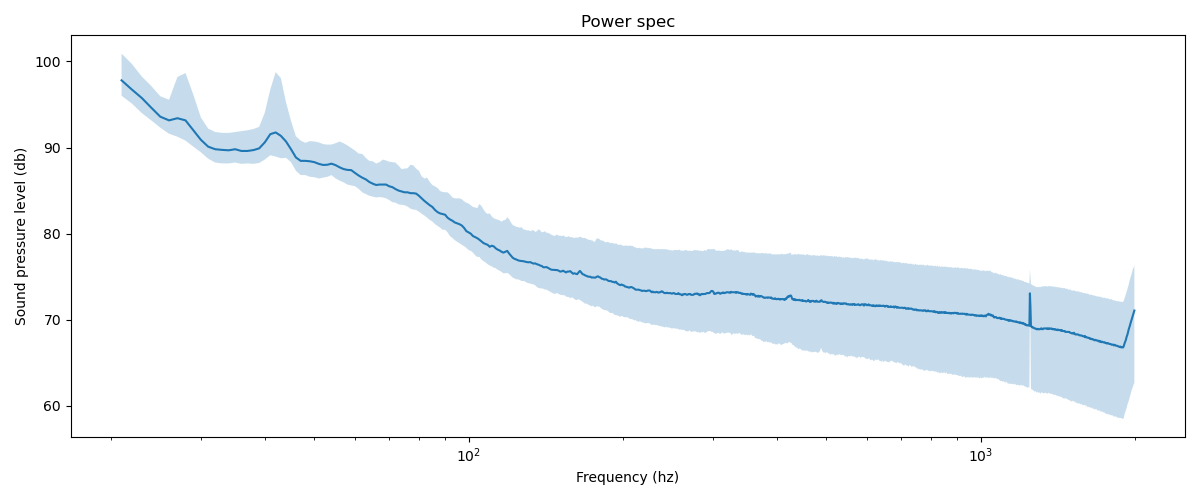

In [149]:
# Plot everything
plot_power_spec(ds, title='Power spec')

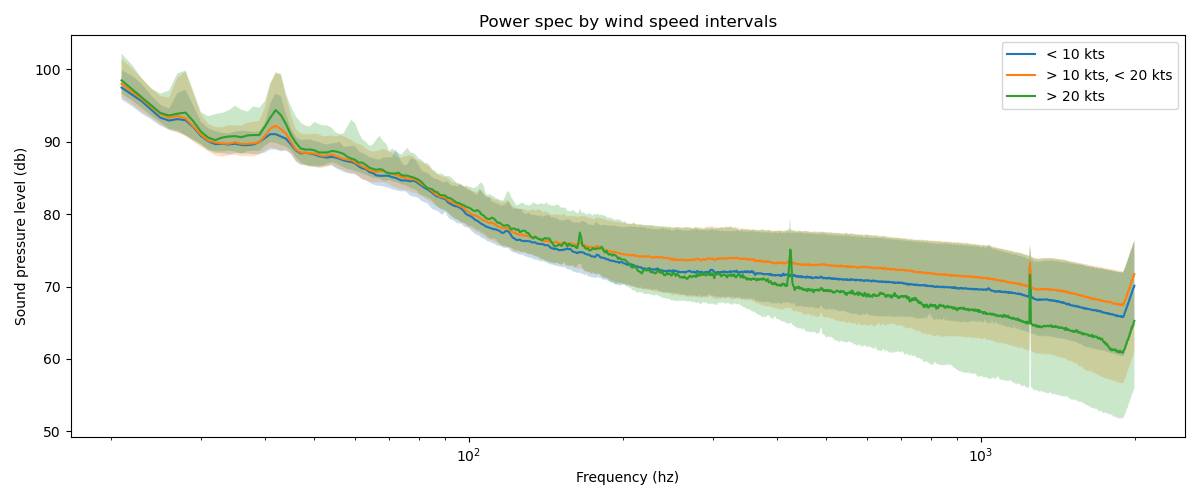

In [150]:
# Plot wind speed intervals
plot_power_spec(
    ds,
    conditions=[
        (ds[wind_var_kts] <= 10, '< 10 kts'),
        ((ds[wind_var_kts] > 10) & (ds[wind_var] <= 20), '> 10 kts, < 20 kts'),
        (ds[wind_var_kts] > 20, '> 20 kts')
    ],
    title='Power spec by wind speed intervals'
)

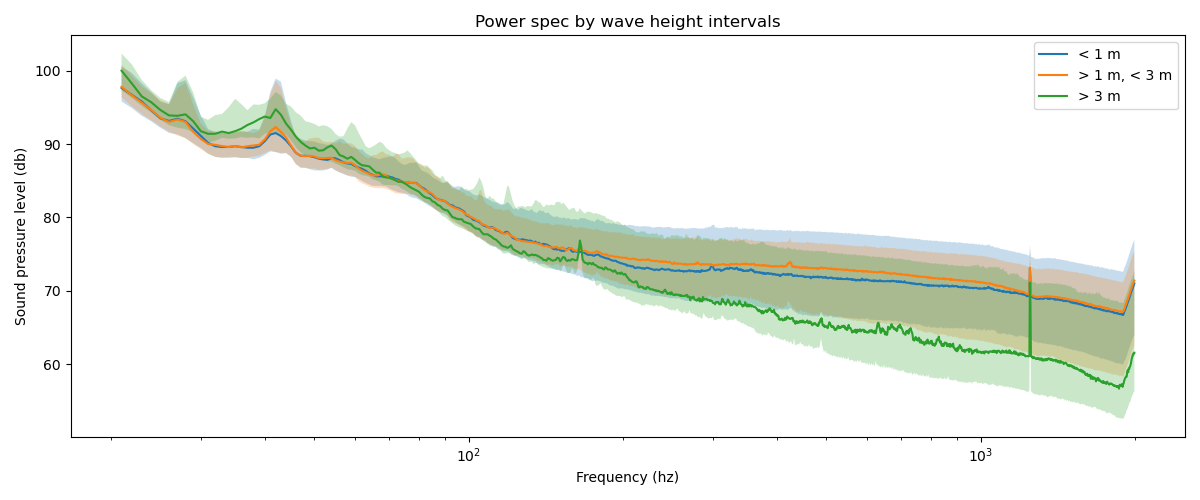

In [151]:
# Plot waves height intervals
plot_power_spec(
    ds,
    conditions=[
        (ds[wave_var] <= 1, '< 1 m'),
        ((ds[wave_var] > 1) & (ds[wave_var] <= 3), '> 1 m, < 3 m'),
        (ds[wave_var] > 3, '> 3 m')
    ],
    title='Power spec by wave height intervals'
)

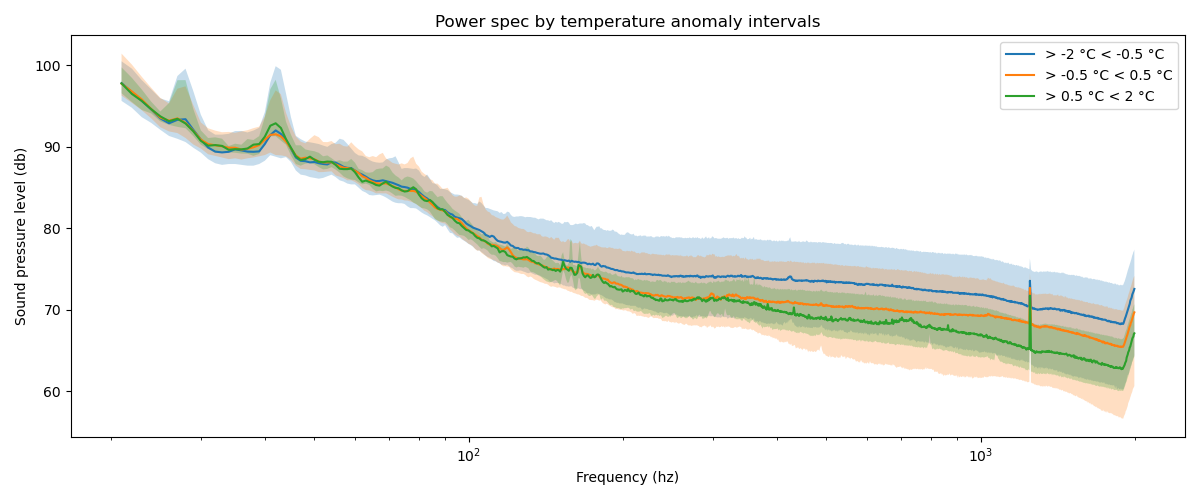

In [152]:
# Plot temperature anomaly intervals
plot_power_spec(
    ds,
    conditions=[
        (ds[anomaly_var] < -2, '< -2 °C'),
        ((ds[anomaly_var] < -.5) & (ds[anomaly_var] >= -2), '> -2 °C < -0.5 °C'),
        ((ds[anomaly_var] < .5) & (ds[anomaly_var] >= -.5), '> -0.5 °C < 0.5 °C'),
        ((ds[anomaly_var] >= .5) & (ds[anomaly_var] <= 2), '> 0.5 °C < 2 °C'),
        (ds[anomaly_var] > 2, '> 2 °C')
    ],

    title='Power spec by temperature anomaly intervals'
)